# PACKAGES IMPORT

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import initializers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# DATA LOADING


In [4]:
data=np.load('/kaggle/input/data-assignment2/training_data.npy', allow_pickle=True)

In [5]:
categories=np.load('/kaggle/input/data-assignment2/categories.npy', allow_pickle=True)

In [6]:
valid_periods=np.load('/kaggle/input/data-assignment2/valid_periods.npy', allow_pickle=True)

# RECONSTRUCTION OF THE TIME SERIES

In [7]:
recovered_series = []

for i in range(len(data)):
    start, end = valid_periods[i]
    series = data[i][start:end]
    recovered_series.append(series)

categorized_series = {category: [] for category in ['A', 'B', 'C', 'D', 'E', 'F']}

for i, category_code in enumerate(categories):
    category = category_code.item()  # Extract the string value
    categorized_series[category].append(recovered_series[i])

# Data Distribution Analysis

There are 5728 time series of category A
There are 10987 time series of category B
There are 10017 time series of category C
There are 10016 time series of category D
There are 10975 time series of category E
There are 277 time series of category F


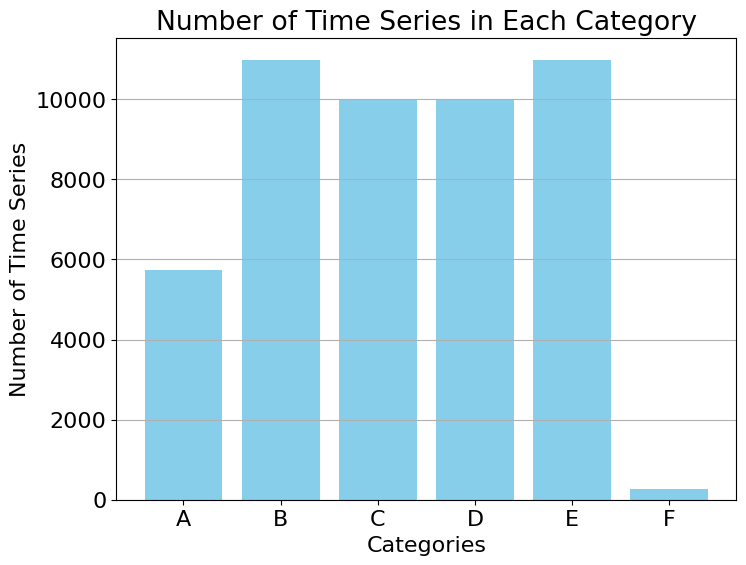

In [8]:
quick_counter = 0
n_samples_cat = []
for category in ['A', 'B', 'C', 'D', 'E', 'F']:
    num_cat = len(categorized_series[category])
    quick_counter += num_cat
    print(f'There are {num_cat} time series of category {category}')
    n_samples_cat.append(num_cat)
    
categories = ['A', 'B', 'C', 'D', 'E', 'F']
num_time_series = [len(categorized_series[category]) for category in categories]

plt.figure(figsize=(8, 6))
plt.bar(categories, num_time_series, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Time Series')
plt.title('Number of Time Series in Each Category')
plt.grid(axis='y')
plt.show()
    
#print(quick_counter) # Check if everything's fine
#print(n_samples_cat)

# VISUALIZE THE TIME SERIES

In [9]:
# Access the first 10 elements of each category
first_10_elements = {category: categorized_series[category][:10] for category in categorized_series}

# Print the first 10 elements of each category along with their lengths
for category, elements in first_10_elements.items():
    print(f"Category {category}:")
    for idx, element in enumerate(elements, start=1):
        print(f"Element {idx}: Length - {len(element)}")
    print("\n")

Category A:
Element 1: Length - 240
Element 2: Length - 168
Element 3: Length - 168
Element 4: Length - 168
Element 5: Length - 168
Element 6: Length - 168
Element 7: Length - 168
Element 8: Length - 168
Element 9: Length - 168
Element 10: Length - 168


Category B:
Element 1: Length - 336
Element 2: Length - 336
Element 3: Length - 517
Element 4: Length - 364
Element 5: Length - 397
Element 6: Length - 493
Element 7: Length - 300
Element 8: Length - 492
Element 9: Length - 359
Element 10: Length - 660


Category C:
Element 1: Length - 431
Element 2: Length - 168
Element 3: Length - 900
Element 4: Length - 94
Element 5: Length - 94
Element 6: Length - 804
Element 7: Length - 804
Element 8: Length - 804
Element 9: Length - 504
Element 10: Length - 288


Category D:
Element 1: Length - 451
Element 2: Length - 451
Element 3: Length - 451
Element 4: Length - 64
Element 5: Length - 94
Element 6: Length - 648
Element 7: Length - 94
Element 8: Length - 94
Element 9: Length - 804
Element 10: L

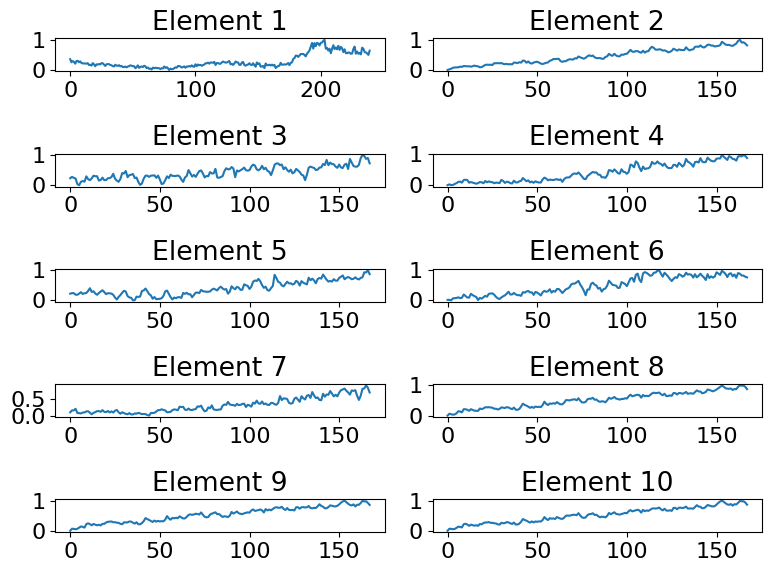

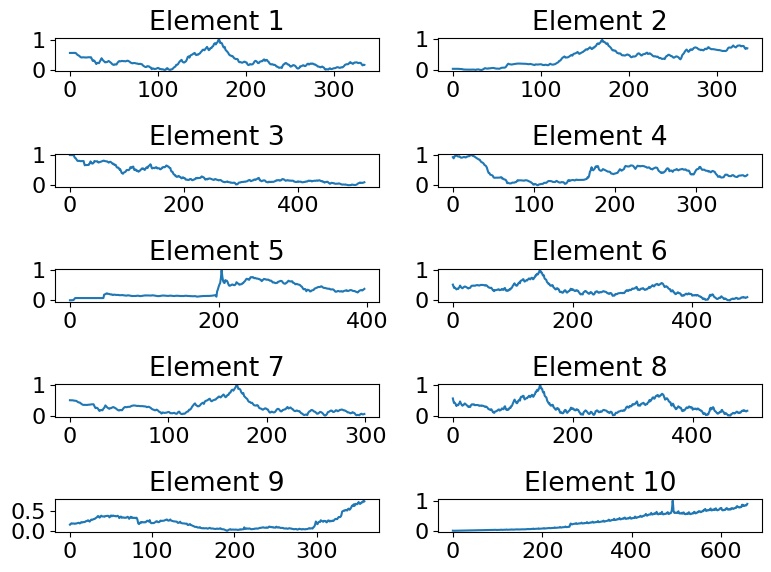

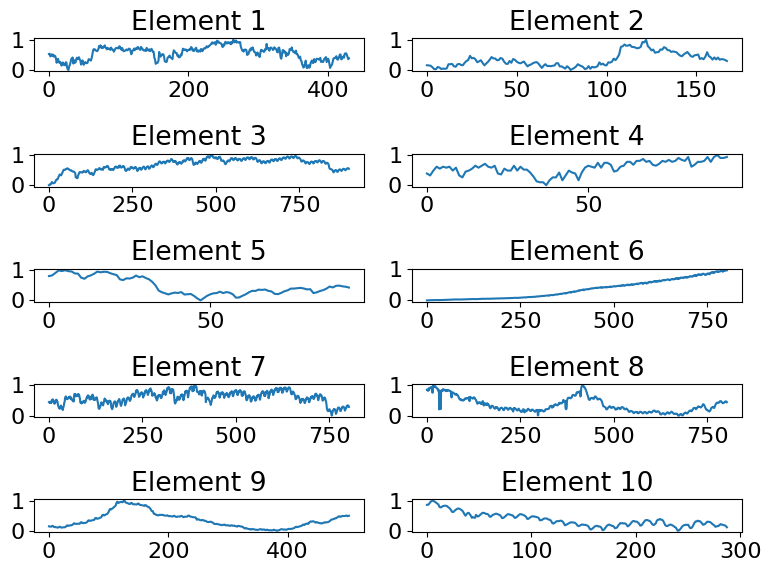

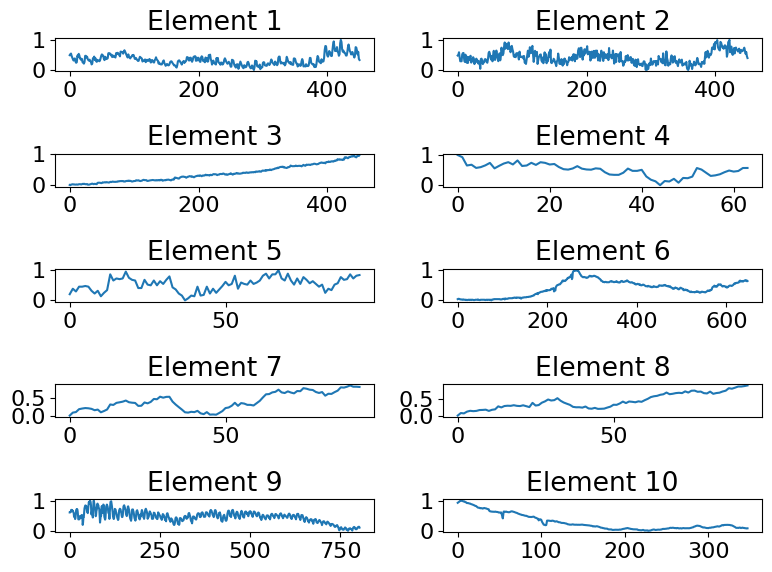

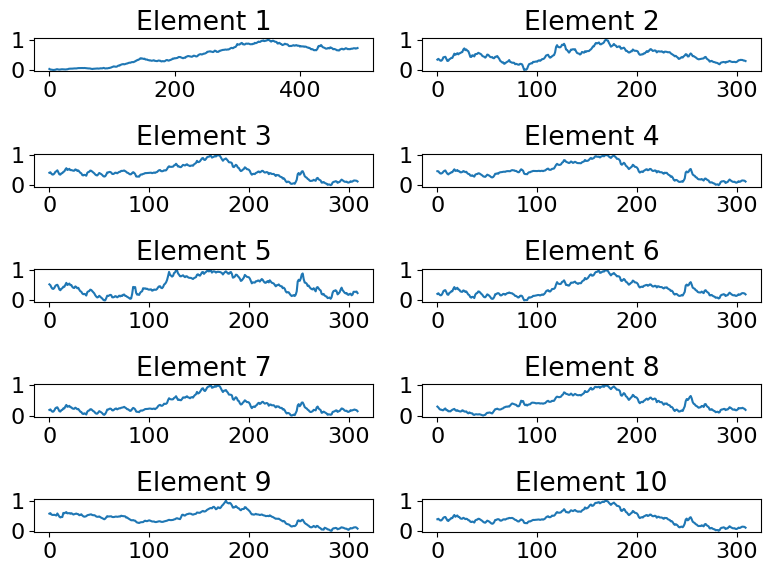

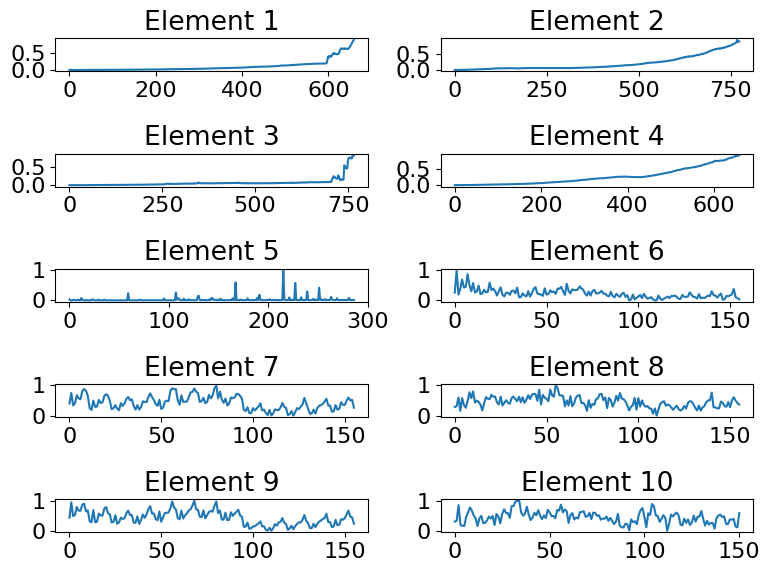

In [10]:
# Plot the first 10 elements of each category on different figures
for category, elements in categorized_series.items():
    plt.figure(figsize=(8, 6))
    plt.title(f"Category {category}")
    
    for idx, element in enumerate(elements[:10], start=1):
        plt.subplot(5, 2, idx)  # Create subplots for each element
        plt.plot(element)
        plt.title(f"Element {idx}")
    
    plt.tight_layout()
    plt.show()

# ANALYSIS OF A SINGLE TIME SEIRES

#### category A

- Smooting the series using a rolling window

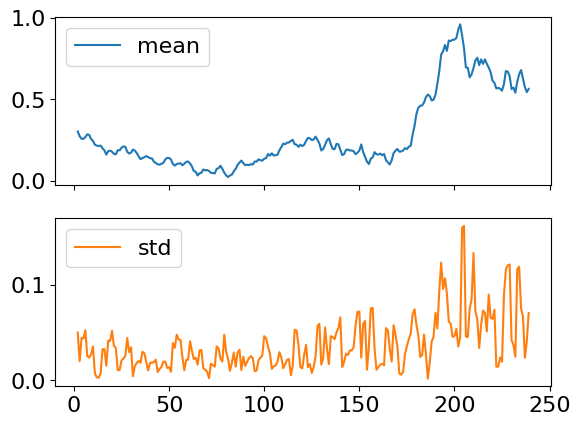

In [11]:
# select a time serie of category A
series=pd.Series(categorized_series["A"][0])


# Observe the aggregation
series.rolling(window=3).agg(['mean', 'std']).plot(subplots=True);

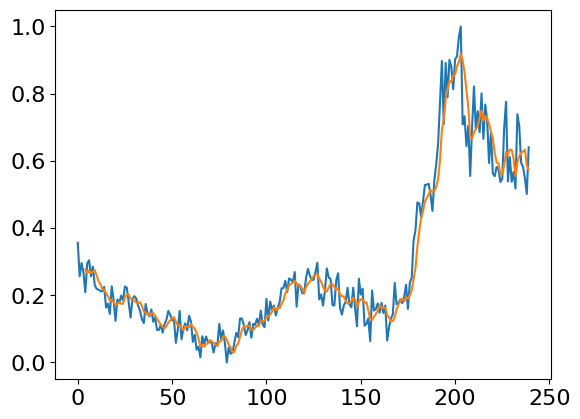

In [12]:

series_rolling=series.rolling(window=5).mean().dropna()

# plot it
plt.plot(series)
plt.plot(series_rolling)

- Study the Autocorrelation

As we can see tha autocorrelation of the denoised version of the time series is less affected by noise

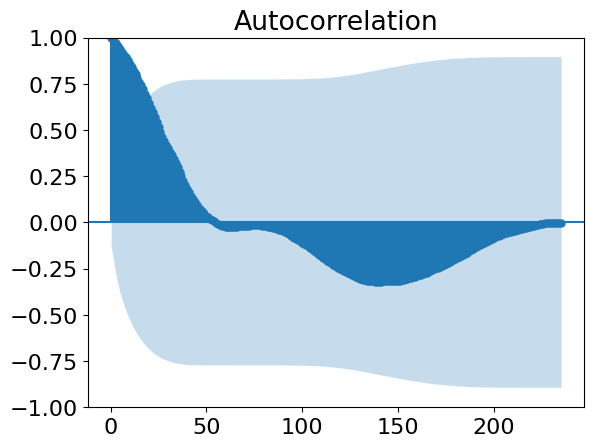

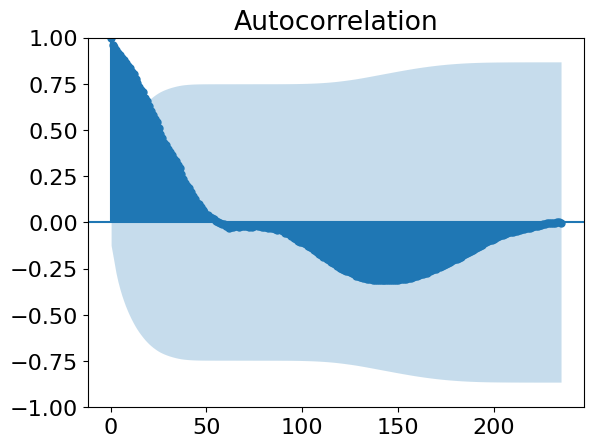

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

A=plot_acf(series_rolling,lags=235)
plot_acf(series,lags=235)

plt.show()

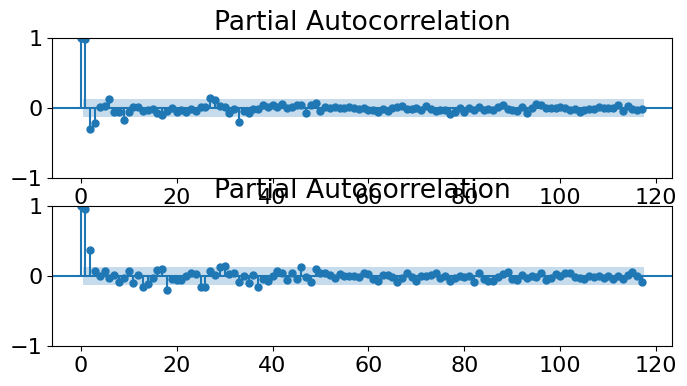

In [14]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8, 4))  # Adjust the figsize as needed
plot_pacf(series_rolling, alpha=.05,ax=ax1,lags=117)
plot_pacf(series, alpha=.05,ax=ax2 ,lags=117)
plt.show()

# FUNCTION TO AUTOMATICALLY DETECT THE WINDOW OF INTEREST BASED ON THE AUTOCORRELATION

In [16]:
# starting from the end of the acf, we iterate backwords until the value of the acf is larger or equal the threshold
def return_window_interest_backwords(acf_values,threshold):
    for i in range(len(acf_values)-1,-1,-1):
        if abs(acf_values[i])>=threshold:
            return i
    
    
    

The red part is the window of interest of the autocorrelation

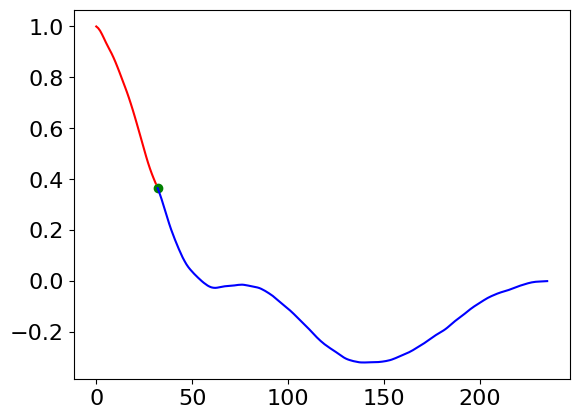

In [17]:
window=return_window_interest_backwords(acf_values,0.35)
plt.figure(2)
first=acf_values[:window]
second=acf_values[window:]
x=np.arange(len(acf_values))

plt.plot(x[:window] , first , c="red")
plt.plot(x[window:] , second , c="blue")
plt.scatter(x=window,y=acf_values[window],c='green')
plt.show()

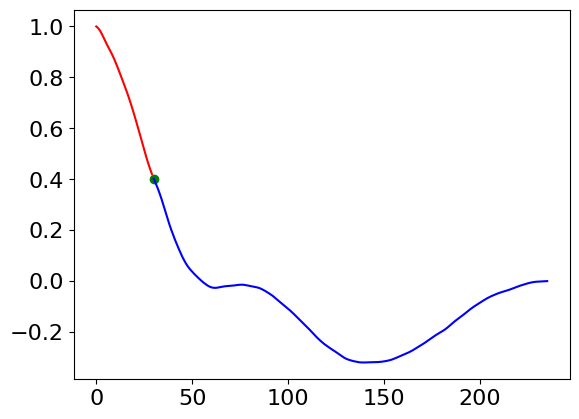

In [18]:
window=return_window_interest_backwords(acf_values,0.4)
plt.figure(2)
first=acf_values[:window]
second=acf_values[window:]
x=np.arange(len(acf_values))

plt.plot(x[:window] , first , c="red")
plt.plot(x[window:] , second , c="blue")
plt.scatter(x=window,y=acf_values[window],c='green')
plt.show()

- Try on many time series

The red part is the window of interest. As we can see, the more the time series seems a white noise the shorter the window of interes is.

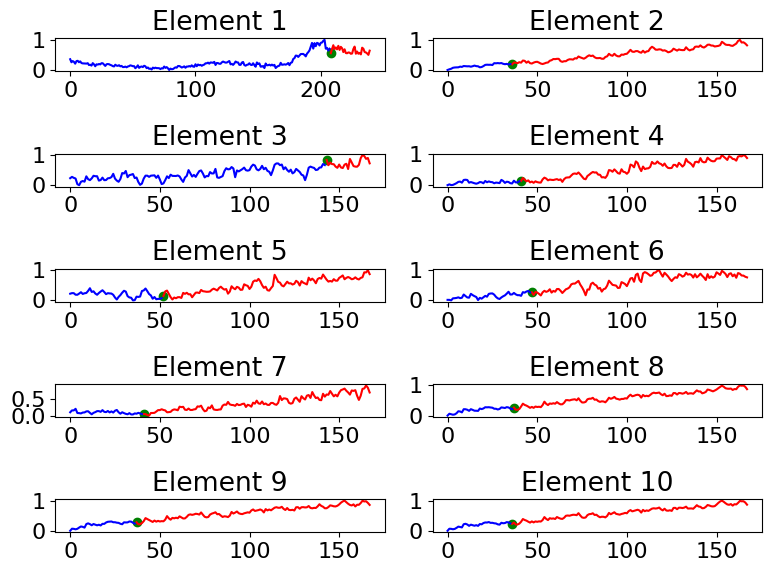

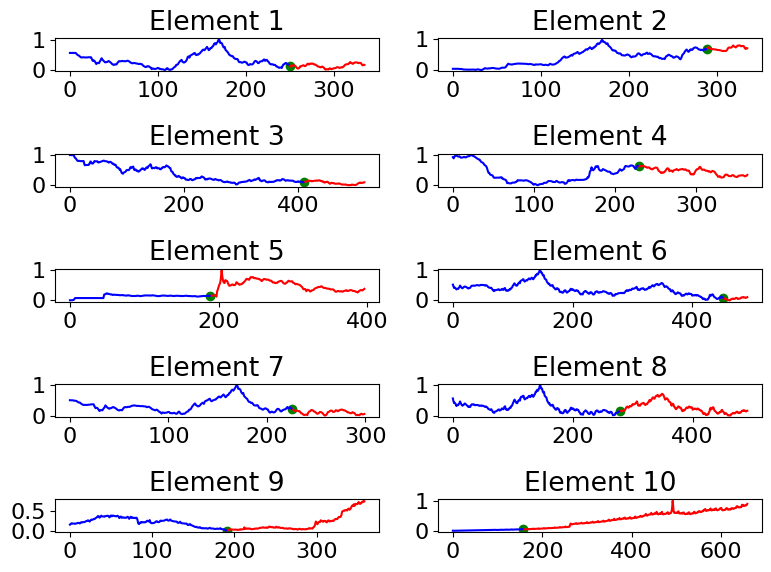

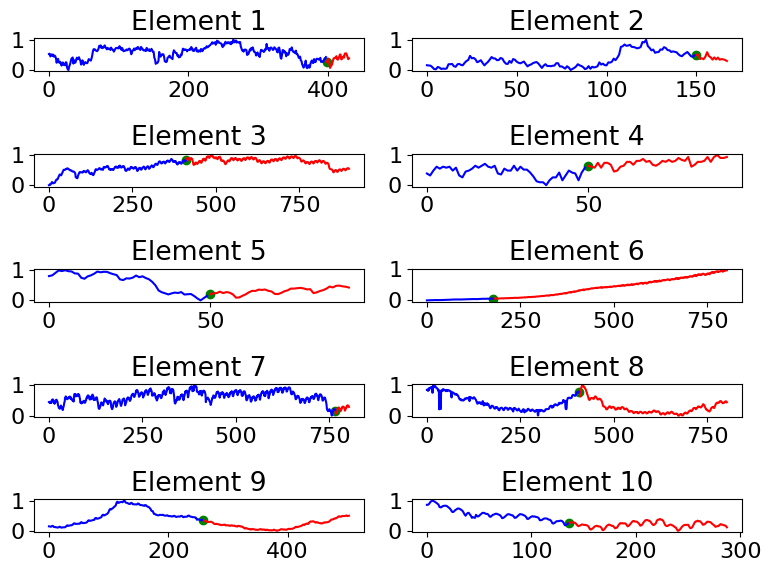

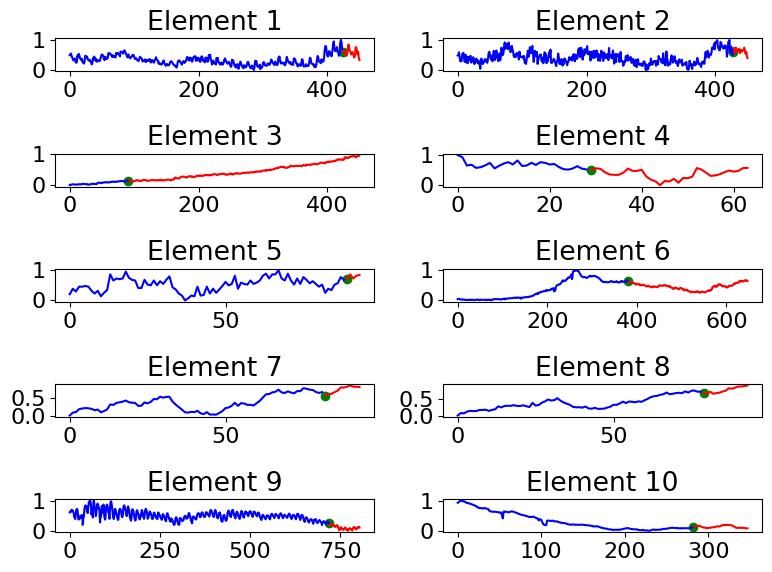

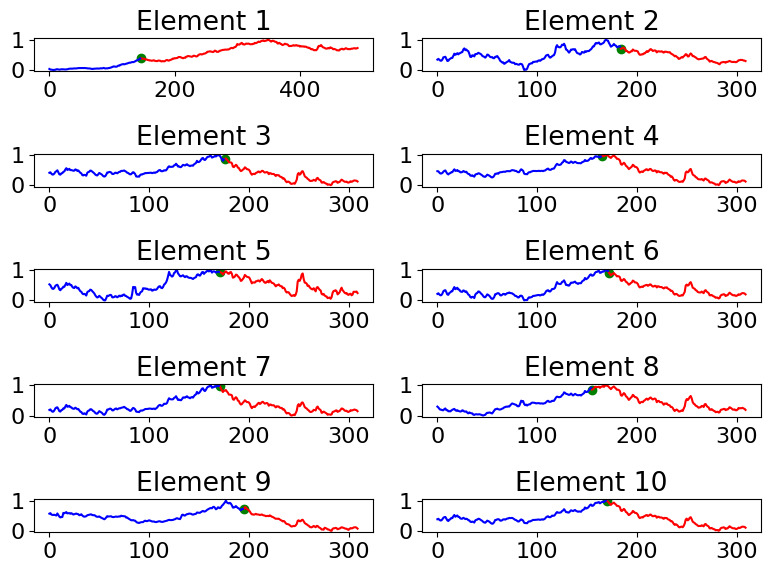

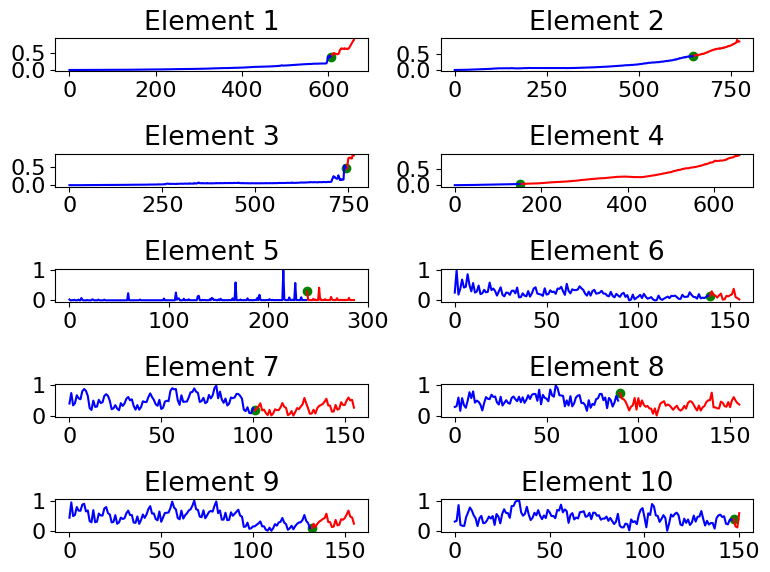

In [19]:
for category, elements in categorized_series.items():
    plt.figure(figsize=(8, 6))
    plt.title(f"Category {category}")
    
    for idx, element in enumerate(elements[:10], start=1):
        element=pd.Series(element)
        rolled_el=element.rolling(window=3).mean().dropna()
        acf_values = acf(rolled_el, alpha=.05, nlags=int(len(rolled_el)))[0]
        window=return_window_interest_backwords(acf_values,0.35)
        first=element[-window:]
        second=element[:-window]
        x=np.arange(len(element))
        
        plt.subplot(5, 2, idx)
        plt.plot(x[-window:] , first , c="red")
        plt.plot(x[:-window] , second , c="blue")
        plt.scatter(x=len(x)-window,y=element[len(x)-window],c='green')
        plt.title(f"Element {idx}")
    
    plt.tight_layout()
    plt.show()

### CHECK STATIONARITY (USELESS)

In [20]:
from statsmodels.tsa.stattools import adfuller

adf = adfuller(series)
print("p-value of time series: %.4f"%adf[1])


p-value of time series: 0.7226


- p value close to 1 so we can not reject the hypotesis that the time series is a random walk => Variance not bounded

#### Stationarize the series

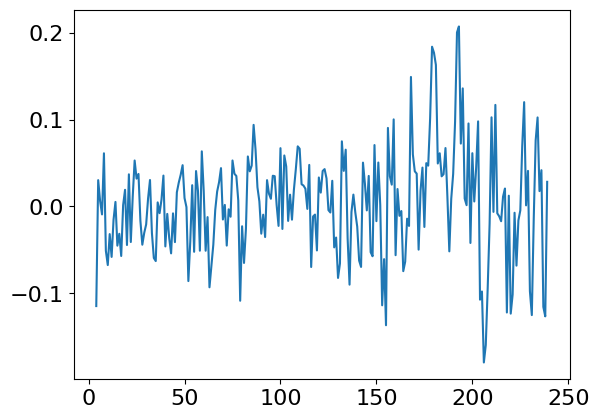

In [21]:
stationarized=np.log(1+series).diff(4).dropna()
plt.plot(stationarized, label="First Differences");

In [22]:
inverse_transofmration=np.exp(stationarized)-1

#### check stationarity of the stationarized

In [23]:
adf = adfuller(stationarized)
print("p-value of time series: %.4f"%adf[1])

p-value of time series: 0.0612


Now the series is not a random walk

# ROBUST SCALER 

In [24]:
from sklearn.preprocessing import RobustScaler

# Assuming `time_series` is a list of numpy arrays
scaler = RobustScaler()
scaled_time_series = [scaler.fit_transform(ts.reshape(-1,1)) for ts in categorized_series["A"]]

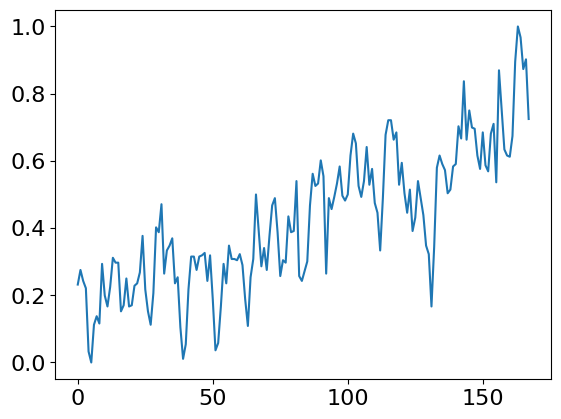

In [25]:
plt.plot(categorized_series["A"][2])

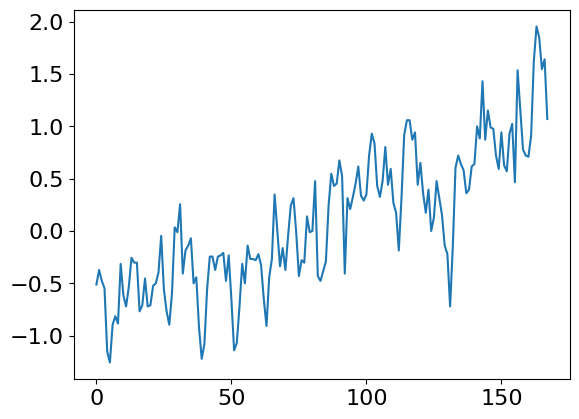

In [26]:
plt.plot(scaled_time_series[2])

# Testing denoising for category A

In [27]:
from sklearn.model_selection import train_test_split

data=categorized_series["A"]

sequence_length = 200


train_data, val_data = train_test_split(data, test_size=0.35, shuffle=True)
tr=[]


def create_sequences(data,sequence_length):
    input_sequences = []
    output_sequences = []
    for series in data:
        for i in range(len(series) - sequence_length - 9):  # Considering 9 samples as the prediction horizon
            input_sequences.append(series[i:i + sequence_length])
            output_sequences.append(series[i + sequence_length:i + sequence_length + 9])
    return np.array(input_sequences), np.array(output_sequences)





#### Fit a model whitout using the denoising

In [24]:
train_input, train_output = create_sequences(train_data,200)

val_input, val_output = create_sequences(val_data,200)

In [58]:
train_input = train_input.reshape(train_input.shape[0], 200)
val_input = val_input.reshape(val_input.shape[0], 200)

In [61]:
model = Sequential([
    Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(200, 1)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.5),
    Dense(128),
    Dropout(0.5),
    Dense(units=9)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 200, 256)          133120    
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 9)                

In [62]:
history=model.fit(train_input, train_output, epochs=10, batch_size=256, validation_data=(val_input, val_output), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1212/1212 [==============================] - 164s 130ms/step - loss: 0.0155 - val_loss: 0.0075 - lr: 0.0010
Epoch 2/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0092 - val_loss: 0.0072 - lr: 0.0010
Epoch 3/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0084 - val_loss: 0.0072 - lr: 0.0010
Epoch 4/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0080 - val_loss: 0.0071 - lr: 0.0010
Epoch 5/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0078 - val_loss: 0.0067 - lr: 0.0010
Epoch 6/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0076 - val_loss: 0.0068 - lr: 0.0010
Epoch 7/10
1212/1212 [==============================] - 131s 108ms/step - loss: 0.0076 - val_loss: 0.0066 - lr: 0.0010
Epoch 8/10
1212/1212 [==============================] - 130s 108ms/step - loss: 0.0076 - val_loss: 0.0063 - lr: 0.0010
Epoch 9/10
1212/1212 [==========================

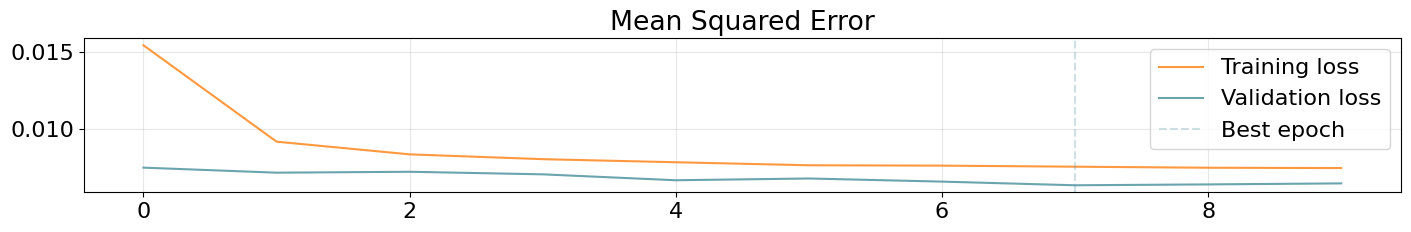

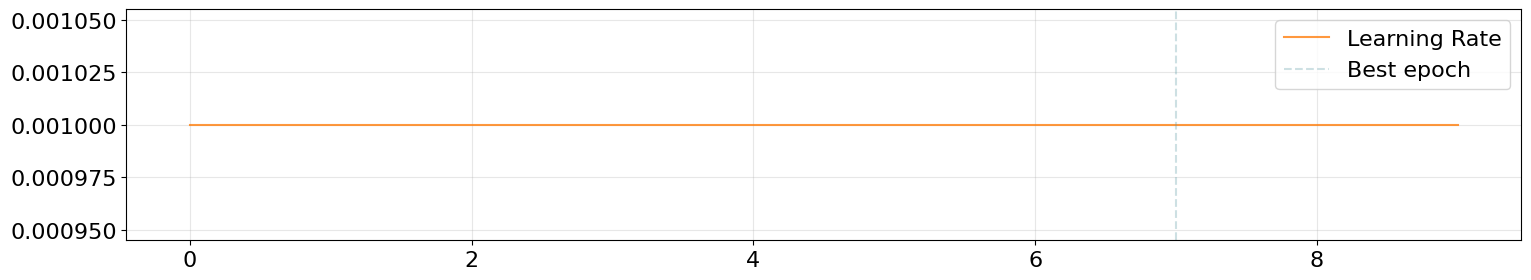

In [63]:
history=history.history
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,2))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

### Fit a model using denoising

In [58]:
import keras.backend as K
from keras.models import Model
# custom filter
def my_filter(shape, window=4, dtype=None):


    f = np.array([
            [[1/window]] for i in range(window)]
        )
    print(shape)
    assert f.shape == shape
    return K.variable(f, dtype='float32')


In [ ]:
# NOTE, KERNEL SIZE HAS TO MATCH THE WINDOW PARAMETER IN THE CUSTOM FILTER
def build_model():
    input_tensor = tfkl.Input(shape=(None,1))

    x = tfkl.Conv1D(filters=1, 
                      kernel_size = 4,
                      kernel_initializer=my_filter,
                      strides=1, 
                      padding='valid') (input_tensor)

    model = Model(inputs=input_tensor, outputs=x)
    return model

- Application of the filter

In [ ]:
model = build_model()
out = model.predict(train_input[0].reshape(1,train_input[0].shape[0]))
print(out.shape)
plt.plot(train_input[0], color='red')
plt.plot(out[0])

In [ ]:
layer= tfkl.Conv1D(filters=1, kernel_size = 4,kernel_initializer=my_filter,strides=1, padding='same')
layer.trainable=False

model = Sequential([
    tfkl.Input(shape=(200,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(200, 1)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.3),
    Dense(128),
    Dropout(0.3),
    Dense(units=9)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

In [130]:
history=model.fit(train_input, train_output, epochs=10, batch_size=256, validation_data=(val_input, val_output), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1212/1212 [==============================] - 139s 109ms/step - loss: 0.0129 - val_loss: 0.0074 - lr: 0.0010
Epoch 2/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0084 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0078 - val_loss: 0.0072 - lr: 0.0010
Epoch 4/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0075 - val_loss: 0.0068 - lr: 0.0010
Epoch 5/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0071 - val_loss: 0.0067 - lr: 0.0010
Epoch 6/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0070 - val_loss: 0.0067 - lr: 0.0010
Epoch 7/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0069 - val_loss: 0.0063 - lr: 0.0010
Epoch 8/10
1212/1212 [==============================] - 130s 107ms/step - loss: 0.0068 - val_loss: 0.0063 - lr: 0.0010
Epoch 9/10
1212/1212 [==========================

# INTEREST WINDOW EXTRACTION

Try a model that, for every time series, uses only the window of interest.

In [63]:
import keras.backend as K
from keras.models import Model
# custom filter
def my_filter(shape, window=3, dtype=None):


    f = np.array([
            [[1/window]] for i in range(window)]
        )
    print(shape)
    assert f.shape == shape
    return K.variable(f, dtype='float32')

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

def create_sequences(data,sequence_length):
    input_sequences = []
    output_sequences = []
    for series in data:
        for i in range(len(series) - sequence_length - 9):  # Considering 9 samples as the prediction horizon
            input_sequences.append(series[i:i + sequence_length])
            output_sequences.append(series[i + sequence_length:i + sequence_length + 9])
    return np.array(input_sequences), np.array(output_sequences)



def create_sequences_window_interest(data, denoising_factor=4 , threshold_acf=0.25):
    input_sequences = []
    output_sequences = []
    for series in data:
        element=pd.Series(series)
        rolled_el=element.rolling(window=denoising_factor).mean().dropna()
        acf_values = acf(rolled_el, alpha=.05, nlags=int(len(rolled_el)))[0]
        window=return_window_interest_backwords(acf_values,threshold_acf)
 
    
        sequence_length=min(window,200)
        for i in range(len(series) - sequence_length - 9): 
            input_sequences.append(series[i:i + sequence_length])
            output_sequences.append(series[i + sequence_length:i + sequence_length + 9])
            
    input_sequences=pad_sequences(input_sequences, maxlen=200, padding='pre', dtype='float32')
    input_sequences = np.ma.masked_equal(input_sequences, 0)
    return input_sequences,np.array(output_sequences)


       

In [116]:
sequences =[[1, 2, 3], [4, 5], [6, 7, 8, 9]]

# Pad sequences with zeros at the beginning (pre-padding)
padded_sequences = pad_sequences(sequences, padding='pre')

# Mask the zero-padded elements in the input sequences
masked_sequences = np.ma.masked_equal(padded_sequences, 0)
masked_sequences

masked_array(
  data=[[--, 1, 2, 3],
        [--, --, 4, 5],
        [6, 7, 8, 9]],
  mask=[[ True, False, False, False],
        [ True,  True, False, False],
        [False, False, False, False]],
  fill_value=0,
  dtype=int32)

In [117]:
data=categorized_series['A']

In [132]:
train_data, val_data = train_test_split(data, test_size=0.35, shuffle=True)

train_inputA, train_outputA = create_sequences_window_interest(train_data, threshold_acf=0)
val_inputA , val_outputA=create_sequences_window_interest(val_data, threshold_acf=0)

train_inputB, train_outputB = create_sequences(train_data,200)
val_inputB , val_outputB=create_sequences(val_data,200)
#plt.plot(train_data[0])

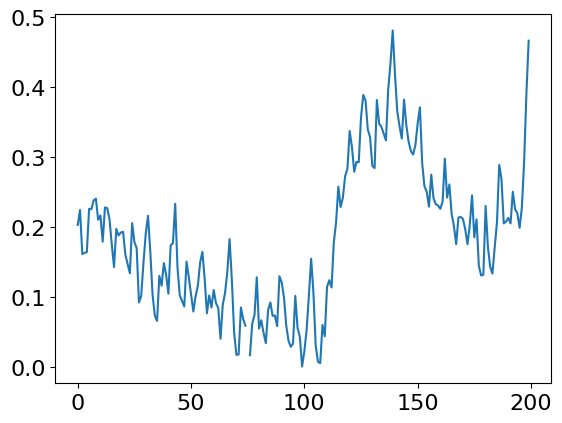

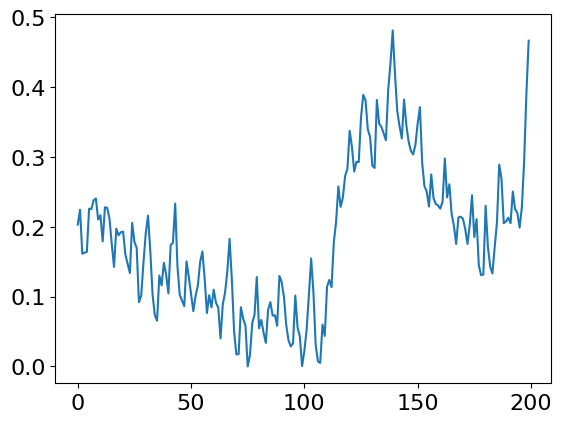

In [133]:
plt.figure(1)
plt.plot(train_inputA[0])

plt.figure(2)
plt.plot(train_inputB[0])

In [137]:
layer= tfkl.Conv1D(filters=1, kernel_size = 3,kernel_initializer=my_filter,strides=1, padding='valid')
layer.trainable=False

model = Sequential([
    #tfkl.Input(shape=(200,1)),
    tfkl.Masking(mask_value=0., input_shape=(None,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(200, 1)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.3),
    Dense(128),
    Dropout(0.3),
    Dense(units=9)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

(3, 1, 1)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_9 (Masking)         (None, None, 1)           0         
                                                                 
 conv1d_16 (Conv1D)          (None, None, 1)           4         
                                                                 
 bidirectional_30 (Bidirect  (None, None, 256)         133120    
 ional)                                                          
                                                                 
 bidirectional_31 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_30 (Dense)            (None, 128)   

#### the fit is interrupted because, after many attempts the results were not promising

In [135]:
history=model.fit(train_inputB, train_outputB, epochs=10, batch_size=256, validation_data=(val_inputB, val_outputB), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1192/1192 [==============================] - 138s 110ms/step - loss: 0.0134 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/10
1192/1192 [==============================] - 129s 108ms/step - loss: 0.0088 - val_loss: 0.0070 - lr: 0.0010
Epoch 3/10
1192/1192 [==============================] - 129s 108ms/step - loss: 0.0081 - val_loss: 0.0068 - lr: 0.0010
Epoch 4/10
 199/1192 [====>.........................] - ETA: 1:27 - loss: 0.0079

KeyboardInterrupt: 

In [138]:
history=model.fit(train_inputA, train_outputA, epochs=10, batch_size=256, validation_data=(val_inputA, val_outputA), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1192/1192 [==============================] - 137s 110ms/step - loss: 0.0134 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/10
 270/1192 [=====>........................] - ETA: 1:21 - loss: 0.0092

KeyboardInterrupt: 

# ANALYSIS OF WINDOW SIZE

Here we study the distribution of the time window over the dataset

- Build a stratified set for trainin experiments

In [29]:
exp_tr=[]
exp_ts=[]
for key in categorized_series.keys():
    #print(categorized_series[key]
    data1, data2 = train_test_split(categorized_series[key], test_size=0.15, shuffle=True)
    data1, data2 = train_test_split(data2, test_size=0.35, shuffle=True)

    exp_tr+=data1
    exp_ts+=data2

    

In [30]:
def return_window_distribution(data, rolling=4 , threshold=0.2 , plot=True):
    windows=[]
    for el in data:
        element=pd.Series(el)
        rolled_el=element.rolling(window=rolling).mean().dropna()
        acf_values = acf(rolled_el, alpha=.05, nlags=int(len(rolled_el)))[0]
        window=return_window_interest_backwords(acf_values,threshold)
        windows.append(window)
        
    if plot:
        plt.hist(windows)
        plt.show()
        
    return windows

##### Distribution of the time windows fo each category

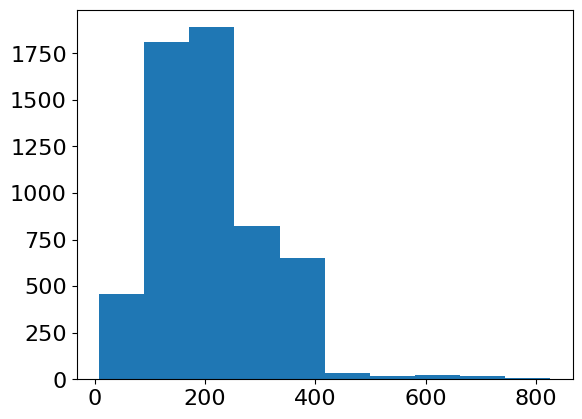

In [31]:
catA=return_window_distribution(categorized_series["A"])

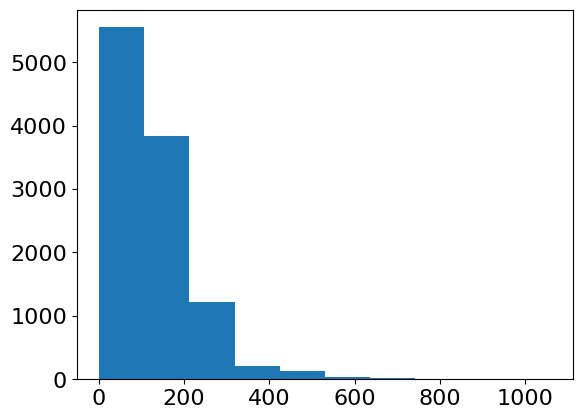

In [32]:
catB=return_window_distribution(categorized_series["B"])

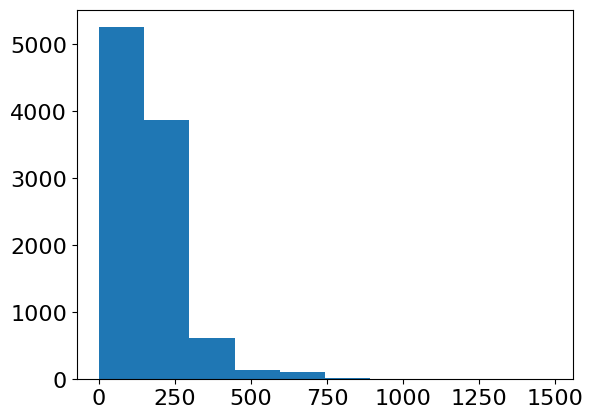

In [33]:
catC=return_window_distribution(categorized_series["C"])

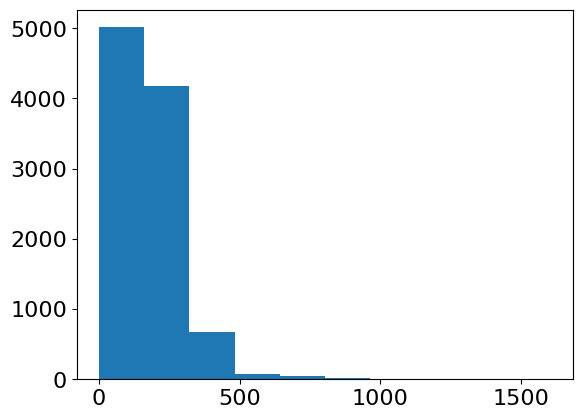

In [34]:
catD=return_window_distribution(categorized_series["D"])

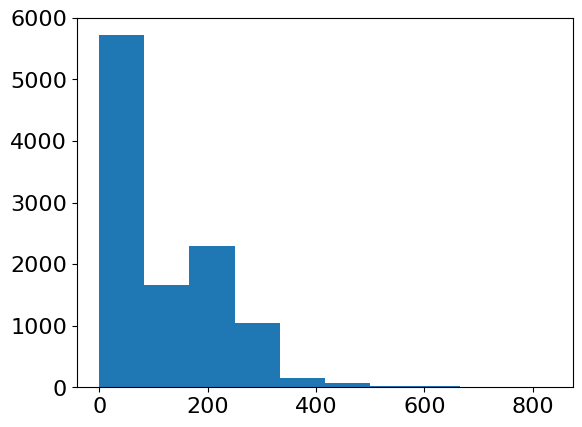

In [35]:
catD=return_window_distribution(categorized_series["E"])

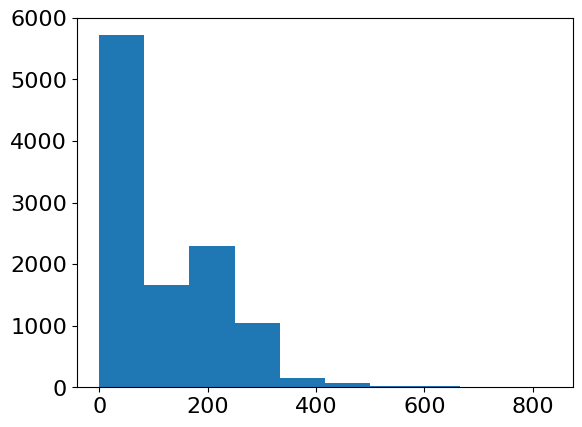

In [36]:
catE=return_window_distribution(categorized_series["E"])

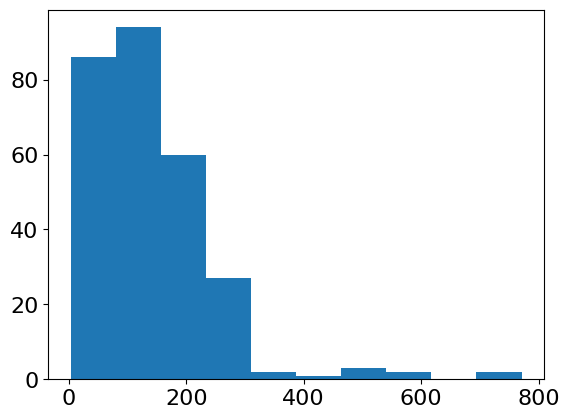

In [37]:
catF=return_window_distribution(categorized_series["F"])

(array([2.8214e+04, 1.7776e+04, 2.2620e+03, 4.6200e+02, 1.9400e+02,
        3.5000e+01, 1.0000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([   0. ,  148.3,  296.6,  444.9,  593.2,  741.5,  889.8, 1038.1,
        1186.4, 1334.7, 1483. ]),
 <BarContainer object of 10 artists>)

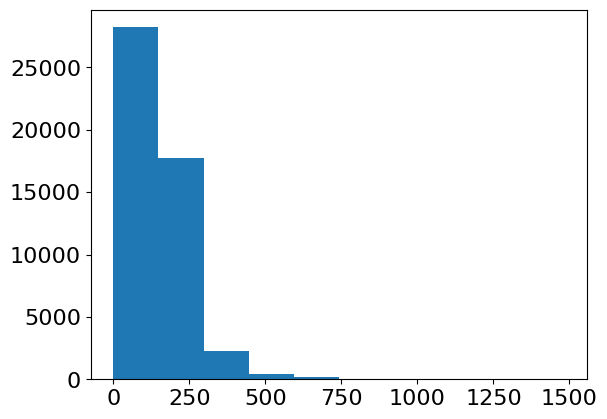

In [38]:
windows=catA+catB+catC+catD+catE+catF
plt.hist(windows)

In [39]:
np.mean(windows)

138.97926836740947

- Try different time windows

In [43]:
def create_sequences(data,sequence_length):
    input_sequences = []
    output_sequences = []
    for series in data:
        for i in range(len(series) - sequence_length - 9):  # Considering 9 samples as the prediction horizon
            input_sequences.append(series[i:i + sequence_length])
            output_sequences.append(series[i + sequence_length:i + sequence_length + 9])
    return np.array(input_sequences), np.array(output_sequences)

import keras.backend as K
from keras.models import Model
# custom filter
def my_filter(shape, window=3, dtype=None):


    f = np.array([
            [[1/window]] for i in range(window)]
        )
    print(shape)
    assert f.shape == shape
    return K.variable(f, dtype='float32')

In [57]:
exp_tr_inA, exp_tr_outA = create_sequences(exp_tr,200)
exp_val_inA , exp_val_outA=create_sequences(exp_ts,200)

exp_tr_inB, exp_tr_outB = create_sequences(exp_tr,175)
exp_val_inB , exp_val_outB=create_sequences(exp_ts,175)

exp_tr_inC, exp_tr_outC = create_sequences(exp_tr,225)
exp_val_inC , exp_val_outC=create_sequences(exp_ts,225)

exp_tr_inD, exp_tr_outD = create_sequences(exp_tr,150)
exp_val_inD , exp_val_outD=create_sequences(exp_ts,150)

In [56]:
layer= tfkl.Conv1D(filters=1, kernel_size = 3,kernel_initializer=my_filter,strides=1, padding='same')
layer.trainable=False

modelA = Sequential([
    tfkl.Input(shape=(200,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.35),
    Dense(128),
    Dropout(0.35),
    Dense(units=9)
])

modelB = Sequential([
    tfkl.Input(shape=(175,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.35),
    Dense(128),
    Dropout(0.35),
    Dense(units=9)
])

modelC = Sequential([
    tfkl.Input(shape=(225,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.35),
    Dense(128),
    Dropout(0.35),
    Dense(units=9)
])

modelD = Sequential([
    tfkl.Input(shape=(150,1)),
    layer,
    Bidirectional(LSTM(units=128, return_sequences=True)),
    Bidirectional(LSTM(units=128)),
    Dropout(0.35),
    Dense(128),
    Dropout(0.35),
    Dense(units=9)
])

# Compile the model
modelA.compile(optimizer='adam', loss='mean_squared_error')
modelB.compile(optimizer='adam', loss='mean_squared_error')
modelC.compile(optimizer='adam', loss='mean_squared_error')
modelD.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
modelB.summary()

(3, 1, 1)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           multiple                  4         
                                                                 
 bidirectional_28 (Bidirect  (None, 175, 256)          133120    
 ional)                                                          
                                                                 
 bidirectional_29 (Bidirect  (None, 256)               394240    
 ional)                                                          
                                                                 
 dropout_28 (Dropout)        (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 128)               32896     
                                                                 
 dropout_29 (Dropout)        (None, 128)   

In [51]:
history=modelA.fit(exp_tr_inA, exp_tr_outA, epochs=10, batch_size=256, validation_data=(exp_val_inA, exp_val_outA), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
880/880 [==============================] - 113s 113ms/step - loss: 0.0148 - val_loss: 0.0082 - lr: 0.0010
Epoch 2/10
880/880 [==============================] - 98s 111ms/step - loss: 0.0099 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/10
880/880 [==============================] - 98s 111ms/step - loss: 0.0093 - val_loss: 0.0081 - lr: 0.0010
Epoch 4/10
880/880 [==============================] - 98s 111ms/step - loss: 0.0089 - val_loss: 0.0079 - lr: 0.0010
Epoch 5/10
880/880 [==============================] - 98s 111ms/step - loss: 0.0087 - val_loss: 0.0079 - lr: 0.0010
Epoch 6/10
880/880 [==============================] - 97s 111ms/step - loss: 0.0084 - val_loss: 0.0074 - lr: 0.0010
Epoch 7/10
880/880 [==============================] - 97s 111ms/step - loss: 0.0081 - val_loss: 0.0076 - lr: 0.0010
Epoch 8/10
880/880 [==============================] - 97s 111ms/step - loss: 0.0080 - val_loss: 0.0075 - lr: 0.0010
Epoch 9/10
880/880 [==============================] - 97s 110ms/step - 

In [52]:
history=modelB.fit(exp_tr_inB, exp_tr_outB, epochs=10, batch_size=256, validation_data=(exp_val_inB, exp_val_outB), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1099/1099 [==============================] - 116s 100ms/step - loss: 0.0140 - val_loss: 0.0083 - lr: 0.0010
Epoch 2/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0096 - val_loss: 0.0084 - lr: 0.0010
Epoch 3/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0091 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0089 - val_loss: 0.0080 - lr: 0.0010
Epoch 5/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0087 - val_loss: 0.0081 - lr: 0.0010
Epoch 6/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0083 - val_loss: 0.0073 - lr: 0.0010
Epoch 7/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0080 - val_loss: 0.0073 - lr: 0.0010
Epoch 8/10
1099/1099 [==============================] - 108s 98ms/step - loss: 0.0079 - val_loss: 0.0071 - lr: 0.0010
Epoch 9/10
1099/1099 [==============================] -

In [55]:
history=modelC.fit(exp_tr_inC, exp_tr_outC, epochs=10, batch_size=256, validation_data=(exp_val_inC, exp_val_outC), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
691/691 [==============================] - 95s 126ms/step - loss: 0.0159 - val_loss: 0.0084 - lr: 0.0010
Epoch 2/10
691/691 [==============================] - 85s 124ms/step - loss: 0.0100 - val_loss: 0.0080 - lr: 0.0010
Epoch 3/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0094 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0090 - val_loss: 0.0078 - lr: 0.0010
Epoch 5/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0087 - val_loss: 0.0080 - lr: 0.0010
Epoch 6/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0086 - val_loss: 0.0076 - lr: 0.0010
Epoch 7/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0085 - val_loss: 0.0075 - lr: 0.0010
Epoch 8/10
691/691 [==============================] - 85s 123ms/step - loss: 0.0083 - val_loss: 0.0072 - lr: 0.0010
Epoch 9/10
691/691 [==============================] - 85s 123ms/step - l

In [58]:
history=modelD.fit(exp_tr_inD, exp_tr_outD, epochs=10, batch_size=256, validation_data=(exp_val_inD, exp_val_outD), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), 
                                                                                                                    tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-5)
                                                                                                                         ])

Epoch 1/10
1343/1343 [==============================] - 123s 86ms/step - loss: 0.0133 - val_loss: 0.0083 - lr: 0.0010
Epoch 2/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0094 - val_loss: 0.0083 - lr: 0.0010
Epoch 3/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0089 - val_loss: 0.0082 - lr: 0.0010
Epoch 4/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0086 - val_loss: 0.0078 - lr: 0.0010
Epoch 5/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0082 - val_loss: 0.0075 - lr: 0.0010
Epoch 6/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0081 - val_loss: 0.0075 - lr: 0.0010
Epoch 7/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0079 - val_loss: 0.0073 - lr: 0.0010
Epoch 8/10
1343/1343 [==============================] - 114s 85ms/step - loss: 0.0078 - val_loss: 0.0071 - lr: 0.0010
Epoch 9/10
1343/1343 [==============================] - 